<a href="https://colab.research.google.com/github/scottspurlock/csc401-2021s/blob/main/labs/lab08_srs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 8: Decision Trees


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# This dataset shows passengers from the Titanic
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1ATf3eoCvAKG_I2luCV2gj_GRDUXoybFR')
df.shape

(891, 12)

In [3]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
# Separate out the target and data
y = df['Survived']
X = df[['Pclass', 'Sex', 'SibSp', 'Parch']]
X = pd.get_dummies(X)
X.head()

,Pclass,SibSp,Parch,Sex_female,Sex_male
0,3,1,0,0,1
1,1,1,0,1,0
2,3,0,0,1,0
3,1,1,0,1,0
4,3,0,0,0,1


### Divide the data into randomized training and test partitions. Use 10% of the data as the test set, keeping 90% for training.

In [5]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=0)
Xtest[0:5]

,Pclass,SibSp,Parch,Sex_female,Sex_male
495,3,0,0,0,1
648,3,0,0,0,1
278,3,4,1,0,1
31,1,1,0,1,0
255,3,0,2,1,0


#### Now let's make a decision tree

In [6]:
# Import the library
from sklearn.tree import DecisionTreeClassifier

# Make a tree object
clf = DecisionTreeClassifier(criterion='entropy', random_state=0)

# Fit a model to the training data
clf = clf.fit(Xtrain, ytrain)
clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Visualize the tree


In [7]:
classes = ['survived_false', 'survived_true']

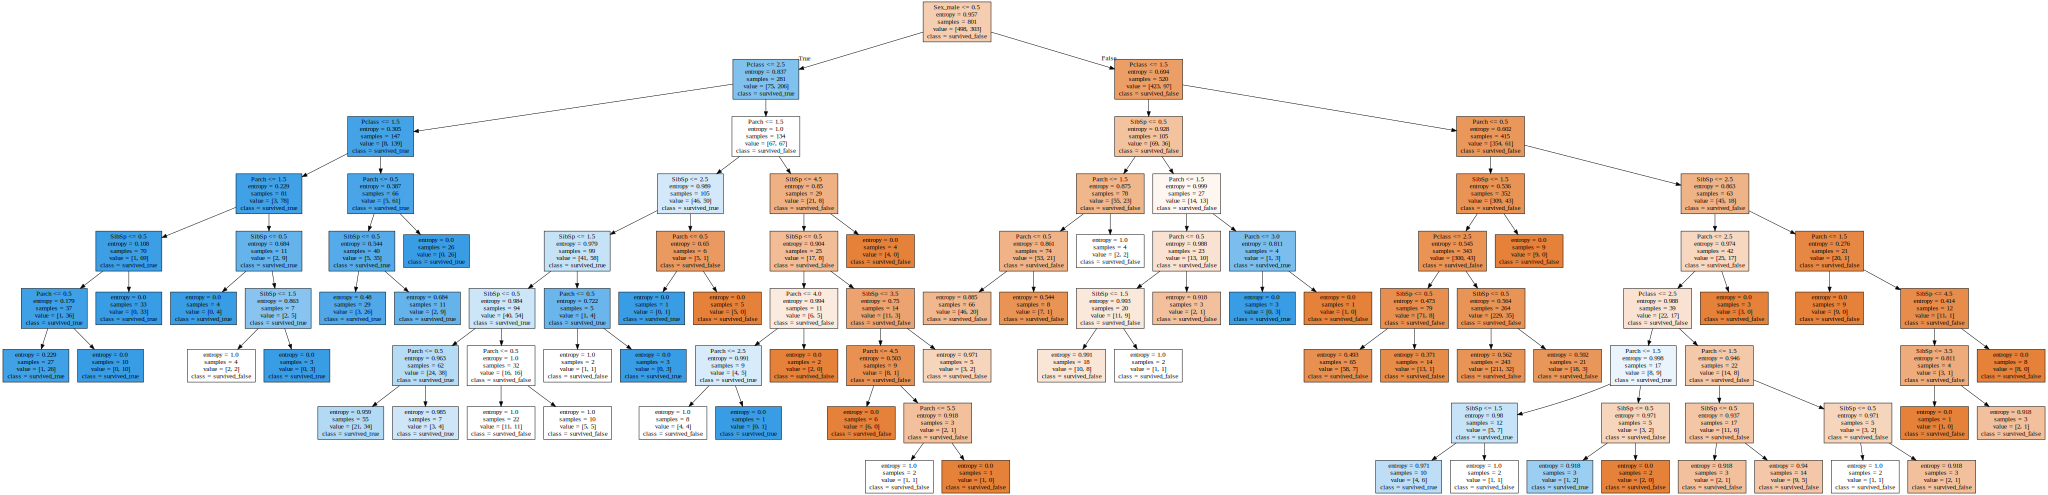

In [8]:
from sklearn.tree import export_graphviz
import graphviz

vis_data = export_graphviz(clf, out_file=None,
                feature_names=Xtrain.columns,
                class_names=['survived_false', 'survived_true'],
                filled=True)

graph = graphviz.Source(vis_data) 
graph

## Interpreting the tree
The top node splits on the sex attribute, suggesting that this is an important attribute to predict whether a passenger survived.

The leaf node with the largest number of samples and 0 entropy includes 33 passengers who survived. These passengers had no siblings or spouses aboard and less than 1.5 parents or children. They were in first class and female.


### How well does the model predict the training data?

In [9]:
from sklearn.metrics import classification_report

print('Training accuracy:')
ypred = clf.predict(Xtrain)
print(classification_report(ytrain, ypred))

Training accuracy:
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       498
           1       0.85      0.63      0.72       303

    accuracy                           0.82       801
   macro avg       0.83      0.78      0.79       801
weighted avg       0.82      0.82      0.81       801



### How well does the model predict the test data?

In [10]:

ypred = clf.predict(Xtest)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        51
           1       0.78      0.64      0.70        39

    accuracy                           0.77        90
   macro avg       0.77      0.75      0.76        90
weighted avg       0.77      0.77      0.76        90



### The accuracy on the training data is only a bit better than on the test data, so the model is overfitting, but not too badly.

## Confusion Matrix

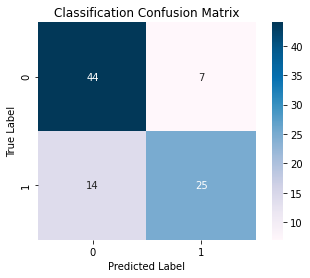

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytest, ypred)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu",
                    xticklabels=clf.classes_,
                    yticklabels=clf.classes_)

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()

## Mistakes
The model is worst when the true label is 1 (pasenger survived), with a recall of 64%.

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0, criterion='entropy')
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print(classification_report(ytest, ypred))


              precision    recall  f1-score   support

           0       0.79      0.90      0.84        51
           1       0.84      0.69      0.76        39

    accuracy                           0.81        90
   macro avg       0.82      0.80      0.80        90
weighted avg       0.82      0.81      0.81        90



## Grid search to identify best hyperparameters for n_estimators and max_depth.

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': np.arange(10, 110, 20),
              'max_depth': np.arange(1, 8)}

# We can incorporate cross-validation into the grid search by specifying cv=5.
model = RandomForestClassifier(criterion='entropy', max_depth=5)
grid = GridSearchCV(model, param_grid, cv=5, verbose=1)
grid.fit(Xtrain, ytrain)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   13.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [14]:
grid.best_params_

{'max_depth': 3, 'n_estimators': 70}

In [15]:
model = grid.best_estimator_
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print(classification_report(ytest, ypred))


              precision    recall  f1-score   support

           0       0.80      0.94      0.86        51
           1       0.90      0.69      0.78        39

    accuracy                           0.83        90
   macro avg       0.85      0.82      0.82        90
weighted avg       0.84      0.83      0.83        90



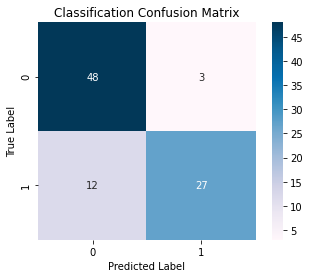

In [16]:
cm = confusion_matrix(ytest, ypred)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu",
                    xticklabels=model.classes_,
                    yticklabels=model.classes_)

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()